In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
print("✓ Libraries loaded")

✓ Libraries loaded


In [4]:
df = pd.read_csv('data_files_stationary/Hospital ER_Data.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumn names:\n{df.columns.tolist()}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nFirst few rows:")
df.head()


Dataset shape: (9216, 12)

Column names:
['Patient Id', 'Patient Admission Date', 'Patient First Inital', 'Patient Last Name', 'Patient Gender', 'Patient Age', 'Patient Race', 'Department Referral', 'Patient Admission Flag', 'Patient Satisfaction Score', 'Patient Waittime', 'Patients CM']

Data types:
Patient Id                     object
Patient Admission Date         object
Patient First Inital           object
Patient Last Name              object
Patient Gender                 object
Patient Age                     int64
Patient Race                   object
Department Referral            object
Patient Admission Flag           bool
Patient Satisfaction Score    float64
Patient Waittime                int64
Patients CM                     int64
dtype: object

First few rows:


,Patient Id,Patient Admission Date,Patient First Inital,Patient Last Name,Patient Gender,Patient Age,Patient Race,Department Referral,Patient Admission Flag,Patient Satisfaction Score,Patient Waittime,Patients CM
0,145-39-5406,20-03-2024 08:47,H,Glasspool,M,69,White,NaN,False,10.0,39,0
1,316-34-3057,15-06-2024 11:29,X,Methuen,M,4,Native American/Alaska Native,NaN,True,NaN,27,0
2,897-46-3852,20-06-2024 09:13,P,Schubuser,F,56,African American,General Practice,True,9.0,55,0
3,358-31-9711,04-02-2024 22:34,U,Titcombe,F,24,Native American/Alaska Native,General Practice,True,8.0,31,0
4,289-26-0537,04-09-2024 17:48,Y,Gionettitti,M,5,African American,Orthopedics,False,NaN,10,0


In [5]:
print("Dataset Info:")
print(df.info())
print(f"\nMissing values:\n{df.isnull().sum()}")
print(f"\nBasic statistics:\n{df.describe()}")

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9216 entries, 0 to 9215
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Patient Id                  9216 non-null   object 
 1   Patient Admission Date      9216 non-null   object 
 2   Patient First Inital        9216 non-null   object 
 3   Patient Last Name           9216 non-null   object 
 4   Patient Gender              9216 non-null   object 
 5   Patient Age                 9216 non-null   int64  
 6   Patient Race                9216 non-null   object 
 7   Department Referral         3816 non-null   object 
 8   Patient Admission Flag      9216 non-null   bool   
 9   Patient Satisfaction Score  2517 non-null   float64
 10  Patient Waittime            9216 non-null   int64  
 11  Patients CM                 9216 non-null   int64  
dtypes: bool(1), float64(1), int64(3), object(7)
memory usage: 801.1+ KB
None

Mi

In [6]:
# Look at all columns to find date-related ones
print("Sample of each column:")
for col in df.columns:
    print(f"\n{col}:")
    print(df[col].head(3))

Sample of each column:

Patient Id:
0    145-39-5406
1    316-34-3057
2    897-46-3852
Name: Patient Id, dtype: object

Patient Admission Date:
0    20-03-2024 08:47
1    15-06-2024 11:29
2    20-06-2024 09:13
Name: Patient Admission Date, dtype: object

Patient First Inital:
0    H
1    X
2    P
Name: Patient First Inital, dtype: object

Patient Last Name:
0    Glasspool
1      Methuen
2    Schubuser
Name: Patient Last Name, dtype: object

Patient Gender:
0    M
1    M
2    F
Name: Patient Gender, dtype: object

Patient Age:
0    69
1     4
2    56
Name: Patient Age, dtype: int64

Patient Race:
0                            White
1    Native American/Alaska Native
2                 African American
Name: Patient Race, dtype: object

Department Referral:
0                 NaN
1                 NaN
2    General Practice
Name: Department Referral, dtype: object

Patient Admission Flag:
0    False
1     True
2     True
Name: Patient Admission Flag, dtype: bool

Patient Satisfaction Score:


In [12]:
date_column = 'Patient Admission Date' 
df[date_column] = pd.to_datetime(df[date_column])

daily_visits = df.groupby(df[date_column].dt.date).size().reset_index()
daily_visits.columns = ['date', 'visits']
daily_visits['date'] = pd.to_datetime(daily_visits['date'])
daily_visits.set_index('date', inplace=True)
daily_visits = daily_visits.sort_index()

print(f"Date range: {daily_visits.index.min()} to {daily_visits.index.max()}")
print(f"Total days: {len(daily_visits)}")
print(f"Average daily visits: {daily_visits['visits'].mean():.1f}")
daily_visits.head()

Date range: 2023-04-01 00:00:00 to 2024-10-30 00:00:00
Total days: 579
Average daily visits: 15.9


,visits
date,
2023-04-01,19
2023-04-02,13
2023-04-03,14
2023-04-04,9
2023-04-05,19


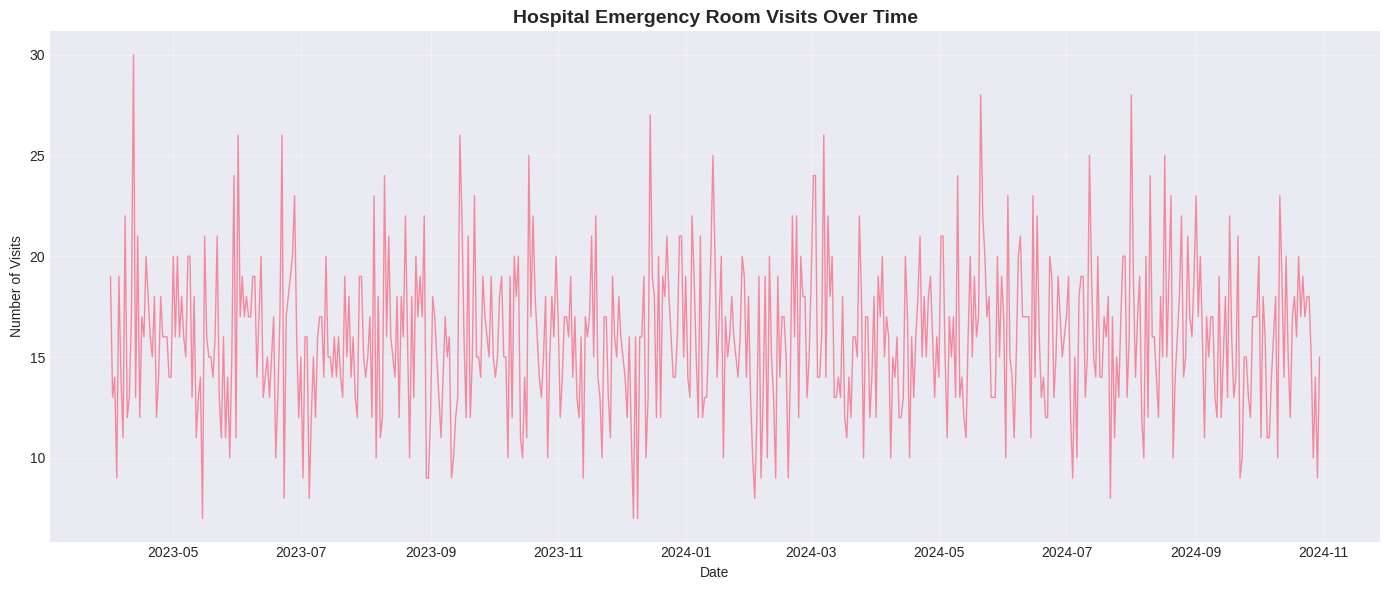

In [13]:
plt.figure(figsize=(14, 6))
plt.plot(daily_visits.index, daily_visits['visits'], linewidth=1, alpha=0.8)
plt.title('Hospital Emergency Room Visits Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Number of Visits')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

```

**Explanation:** 

This is your first look at the time series behavior - arguably the most important plot in the entire analysis.

**Visual Inspection for Stationarity:**

**What You're Looking For:**

1. **Trend (Non-Stationary)**
   - Upward slope: Mean increasing over time
   - Downward slope: Mean decreasing over time
   - Curved: Non-linear trend
   - Flat line with fluctuations: Possibly stationary

2. **Changing Variance (Non-Stationary)**
   - Widening pattern (funnel shape): Variance increasing
   - Narrowing pattern: Variance decreasing
   - Consistent width throughout: Good sign for stationarity

3. **Seasonality (Non-Stationary)**
   - Regular repeating patterns
   - Weekly cycles (peaks every 7 days)
   - Monthly patterns (end-of-month effects)
   - Yearly patterns (summer vs. winter)

4. **Level Shifts (Non-Stationary)**
   - Sudden jumps up or down
   - Structural breaks (policy changes, facility expansion)
   - One-time events (pandemic, natural disaster)

**Code Breakdown:**

`plt.figure(figsize=(14, 6))` - Creates wide plot (14 inches wide, 6 tall)
- Wide format best for time series (emphasizes temporal progression)
- 14:6 ratio balances detail vs. readability

`linewidth=1, alpha=0.8` 
- Thin lines show more data points clearly
- Alpha=0.8 (80% opacity) helps with overlapping lines later

`plt.grid(True, alpha=0.3)` 
- Gridlines help read values
- Light (alpha=0.3) so they don't dominate

`plt.tight_layout()` 
- Automatically adjusts spacing to prevent label cutoff
- Essential for clean, professional plots

**Statistical Concept - Visual Inference:**

Before any statistical test, plot your data! Humans are excellent at pattern recognition:
- Obvious trends/seasonality suggest non-stationarity
- Stationary data looks like "noise" around a constant level
- Visual inspection catches data errors tests might miss

**What Different Patterns Mean for Stationarity:**

**Stationary Pattern:**
```
  ·  ·   ·  ·    ·   ·  ·
 ···· ·· ···· ·· ···· ··
·    ·  ·    ·  ·    ·  ·
─────────────────────────
```
Random fluctuations around constant mean

**Non-Stationary with Trend:**
```
              · ·  ·
         · ·  ·
    · ·  ·
· ·  ·
─────────────────────────
```
Clear upward movement

**Non-Stationary with Seasonality:**
```
 ·    ·    ·    ·
· ·  · ·  · ·  · ·
  ··    ··    ··  
─────────────────────────

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(daily_visits.index, daily_visits['visits'], linewidth=1, alpha=0.8)
plt.title('Hospital Emergency Room Visits Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Number of Visits')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
